In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!kaggle datasets download -d therohk/india-headlines-news-dataset 

 97% 84.0M/86.6M [00:04<00:00, 24.3MB/s]
100% 86.6M/86.6M [00:04<00:00, 18.6MB/s]


In [ ]:
!unzip india-headlines-news-dataset.zip

Archive:  india-headlines-news-dataset.zip
  inflating: india-news-headlines.csv  


In [ ]:
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('india-news-headlines.csv')

In [ ]:
df.sample(n=10)

,publish_date,headline_category,headline_text
942953,20100711,city.ludhiana,Railways to post guards at 130 level crossings
3085527,20190222,city.jaipur,Jaipur gardens to bear plaques with martyrs' n...
1782414,20131228,city.kozhikode,Anti-filariasis campaign comes a cropper in Ko...
3204158,20191018,city.ahmedabad,Gujarat: Con call centre busted in Gandhinagar
3547640,20210905,city.mumbai,Mumbai: Protest against Javed Akhtar's Taliban...
193694,20030317,edit-page,Sledger Shahid
1026413,20101217,city.jaipur,Tiger death: Suspect may undergo brain mapping...
1679653,20130802,india,Chargesheet will fail legal scrutiny: Zee
482770,20070616,edit-page,COUNTER VIEW: No need for F1 racing
101393,20020428,city.pune,Industrialist Agashe felicitated


In [ ]:
df.drop(['publish_date'], axis=1, inplace=True)
print(len(df))
df.sample(n=10)

3650970


,headline_category,headline_text
610327,entertainment.english.hollywood,Sienna; Getty eyeing 11m love nest
778455,business.india-business,Sensex; Nifty gain one per cent each in bullis...
1840094,city.bhubaneswar,Sabyasachis wife joins SoumyasAamaOdishaParty
3057835,tv.news.malayalam,Pearle Maaney wishes Bigg Boss Hindi finalist ...
93638,unknown,City Sports
2981770,india,Case going on for 41 years over 'missing' cour...
1377275,entertainment.hindi.top-10,Top 10 Shah Rukh Khan Controversies
1634937,city.mumbai,Prayers for long life together in vain for new...
2466059,city.ludhiana,Waterlogged track turns breeding ground for mo...
2529502,entertainment.hindi.bollywood,'Pink' to be screened at the UN headquarters i...


In [ ]:
include = ["entertainment", "tech", "science", "sports", "politics", "elections"]
tempdf = df[df.headline_category.str.contains('|'.join(include))]
poll = ["elections", "politics"]
sci = ["science", "tech"]
tempdf.loc[tempdf.headline_category.str.contains("entertainment"), "headline_category"] = "entertainment"
tempdf.loc[tempdf.headline_category.str.contains('|'.join(sci)), "headline_category"] = "scienceandtech"
tempdf.loc[tempdf.headline_category.str.contains("sports"), "headline_category"] = "sports"
tempdf.loc[tempdf.headline_category.str.contains('|'.join(poll)), "headline_category"] = "politics"
tempdf.drop_duplicates(subset = "headline_text", inplace = True)

In [ ]:
tempdf.sample(n=10)

,headline_category,headline_text
1159293,scienceandtech,Tech Mahindra bags contract from Microsoft
1462882,sports,Mithali; Jhulan in top 3 of ICC women's rankings
2100917,sports,Nishikori off to flying start; Tsonga wins on ...
1514935,entertainment,Vidya; Katrina; Kareena are watching you
1909617,entertainment,Keira Knightley: Karaoke is my idea of hell
486558,scienceandtech,Why stress can lead to obesity
98754,entertainment,No 'Gem' for Kajol
700278,entertainment,Tanushree's obsessed with sci-fi
2969489,entertainment,Pics: Check out Adnan Sami's son Azaan's amazi...
3029108,sports,Alexander Zverev's ATP Finals win over Roger F...


In [ ]:
print(len(tempdf))
print(tempdf.groupby(['headline_category']).size())

416272
headline_category
entertainment     225845
politics           17270
scienceandtech     47385
sports            125772
dtype: int64


In [ ]:
training_data1,testing_data1 =  train_test_split(tempdf,test_size=0.1)

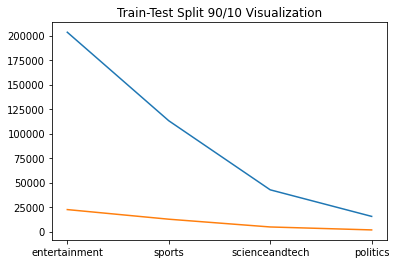

In [ ]:
import matplotlib.pyplot as plt
# plotting distribution of each news_category in training& testing data
plt.plot(training_data1['headline_category'].value_counts())
plt.plot(testing_data1['headline_category'].value_counts())
plt.title('Train-Test Split 90/10 Visualization')
plt.show()

In [ ]:
def tokenization_(training_headings, testing_headings, max_length=20, vocab_size = 35000):
    tokenizer = Tokenizer(num_words = vocab_size, oov_token= '<oov>')
    #Tokenization and padding
 
    tokenizer.fit_on_texts(training_headings)
    word_index = tokenizer.word_index
    training_sequences = tokenizer.texts_to_sequences(training_headings)
    training_padded = pad_sequences(training_sequences,padding= 'post',maxlen = max_length, truncating='post')
 
 
    testing_sequences = tokenizer.texts_to_sequences(testing_headings)
    testing_padded = pad_sequences(testing_sequences,padding= 'post',maxlen = max_length, truncating='post')
 
    return tokenizer,training_padded,testing_padded

In [ ]:
tokenizer,X_train,X_test = tokenization_(training_data1['headline_text'],
                                         testing_data1['headline_text'])
 
labels = {'entertainment':[1,0,0,0], 'politics':[0,1,0,0],
          'scienceandtech':[0,0,1,0], 'sports':[0,0,0,1]}
Y_train = np.array([labels[y] for y in training_data1['headline_category']])
Y_test = np.array([labels[y]  for y in testing_data1['headline_category']])

In [ ]:
def build_model( n, vocab_size, embedding_size):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size,
              embedding_size,input_length=n))
    model.add(tf.keras.layers.GlobalAveragePooling1D()) 
    model.add(tf.keras.layers.Dense(4,activation = 'softmax'))       
    model.compile(loss='categorical_crossentropy',optimizer='adam',
                   metrics='accuracy')
    print(model.summary())
    return model

In [ ]:
epochs = 8
model = build_model(20,35000,20)
history = model.fit(X_train,Y_train,
                    validation_data = (X_test,Y_test),
                    epochs = epochs)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 20)            700000    
                                                                 
 global_average_pooling1d (G  (None, 20)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 4)                 84        
                                                                 
Total params: 700,084
Trainable params: 700,084
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/8
11708/11708 [==============================] - 103s 9ms/step - loss: 0.3368 - accuracy: 0.8843 - val_loss: 0.1597 - val_accuracy: 0.9491
Epoch 2/8
11708/11708 [==============================] - 97s 8ms/step - loss: 0.1285 - accuracy:

In [ ]:
loss, accuracy = model.evaluate(X_train,Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test,Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9792
Testing Accuracy:  0.9594


In [17]:
import re 
import nltk 
import string 
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
wordnet_lemma = WordNetLemmatizer()  
Stopwords = set(stopwords.words('english')) 

def clean_sentence(sentence):
 
    sentence = sentence.replace('-',' - ')
    sentence = sentence.replace('.',' . ')
    sentence = sentence.replace('/',' / ')
    sentence = sentence.replace(',', ' , ')

    Words=sentence.split()
    sentence = ''
    for word in Words:
        word = word.replace("'s",' is')
        word = word.replace("'nt",' not')
        word = word.replace("n't",' not')
        word = word.replace("'d", ' had')
        word = word.replace("'ll",' will')
        word = word.replace("'m",' am')
        word = word.replace("'ve",' have')
        word = word.replace("'re", ' are')
        sentence = sentence + word + ' '
    sentence = re.sub("^\s+"," ",sentence)  
    sentence = ''.join([i for i in sentence if i not in string.punctuation])  
    sentence = ' '.join([i.lower() for i in sentence.split()])   #Normalization
    sentence = ' '.join([i for i in sentence.split() if i not in Stopwords])  # Removing stopwords
    sentence = ' '.join([wordnet_lemma.lemmatize(i) for i in sentence.split()])
    new_ = [re.findall("^[a-z]*$",i) for i in sentence.split() if re.findall("^[a-z]*$",i) !=[] ] 
    sentence = ' '.join([x[0] for x in new_])

    return [sentence]

def predict_label(text) : 
    if (text == '') : 
        return 'None'
    text = clean_sentence(text) 
    text = tokenizer.texts_to_sequences(text)
    padded_text = pad_sequences(text,padding= 'post',maxlen = 20, truncating='post')
    labels = { 0 : 'entertainment', 1 : 'politics', 2 : 'scienceandtech', 3 : 'sports'}
    prediction = list(model.predict(padded_text)[0])
    sorted_pred = sorted(prediction,reverse=True)
    index = prediction.index(sorted_pred[0])
    label = labels[index]
    return label

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [18]:
print(predict_label("indian premier league"))
print(predict_label("bjp announces candidates"))
print(predict_label("Sachin smashes a century"))
print(predict_label("new vaccine discovered for covid 19"))
print(predict_label("kantara breaks all records"))
print(predict_label("modi rally in gujarat tomorrow"))
print(predict_label("apple announces new CEO"))

1/1 [==============================] - 0s 65ms/step
sports
1/1 [==============================] - 0s 17ms/step
politics
1/1 [==============================] - 0s 13ms/step
sports
1/1 [==============================] - 0s 13ms/step
scienceandtech
1/1 [==============================] - 0s 12ms/step
entertainment
1/1 [==============================] - 0s 14ms/step
politics
1/1 [==============================] - 0s 15ms/step
scienceandtech


In [ ]:
!pip install gradio

In [20]:
import gradio as gr

def categorise(headline):
    return predict_label(headline)

demo = gr.Interface(fn=categorise, inputs="text", outputs="text")

demo.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>